# Utilisation du format `Parquet` avec `Python` illustré à partir de

quelques exemples

Lino Galiana

**Ce tutoriel n’est pas encore fini, il sera progressivement enrichi**

Ce tutoriel vise à offrir une approche complémentaire au guide
d’utilisation des données du recensement au format `Parquet` publié sur
[https://ssphub.netlify.app](https://ssphub.netlify.app/post/parquetrp/)
pour accompagner la diffusion de celles-ci par l’Insee.

Il s’agit d’un tutoriel préparé pour l’atelier
[`tuto@mate`](https://mate-shs.cnrs.fr/actions/tutomate/tuto62_parquet_galiana/)
à l’EHESS le 5 novembre 2024. Ce tutoriel est exclusivement en `R`. Les
slides de la présentation sont disponibles ci-dessous:

<div class="callout callout-style-default callout-note callout-titled">
<div class="callout-header d-flex align-content-center">
<div class="callout-icon-container"><i class="callout-icon"></i>
</div>

<div class="callout-title-container flex-fill">
Note
</div>
</div>

Pour retrouver une version `R` équivalente, [c’est
ici](https://linogaliana.github.io/parquet-recensement-tutomate/).

</div>
</div>

<details>

<summary>

Dérouler les *slides* ci-dessous ou [cliquer
ici](https://inseefrlab.github.io/formation-bonnes-pratiques-git-R/slides/complete.html#/partie-1-contr%C3%B4le-de-version-avec-git)
pour afficher les slides en plein écran.

</summary>

<div class="sourceCode" id="cb1"><pre class="sourceCode yaml code-with-copy"><code class="sourceCode yaml"></code><button title="Copy to Clipboard" class="code-copy-button"><i class="bi"></i></button></pre><iframe class="sourceCode yaml code-with-copy" src="https://inseefrlab.github.io/formation-bonnes-pratiques-git-R/slides/complete.html#/partie-1-contr%C3%B4le-de-version-avec-git"></iframe></div>

</details>

Il propose des exemples variés pour illustrer la simplicité d’usage du
format `Parquet`. Parmi ceux-ci, à partir du recensement de la
population:

-   Liste des exemples à venir

# Librairies utilisées

Ce tutoriel utilisera plusieurs librairies `Python`. Celles-ci peuvent
être importées ainsi

``` bash
pip install -r requirements.txt
```

# Téléchargement des fichiers

Pour commencer, nous allons télécharger les fichiers depuis internet
pour limiter les échanges réseaux. Comme nous le verrons ultérieurement,
ce n’est en fait pas indispensable car `duckdb` optimise les données
téléchargées à chaque requête.

In [1]:
import requests
import os
from tqdm import tqdm
from pathlib import Path

Path("data").mkdir(parents=True, exist_ok=True)

def download_file(url: str, filename: str) -> None:
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        # Récupérer la taille totale du fichier depuis les headers (si disponible)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kilobyte

        # Afficher un message si le content-length n'est pas disponible
        if total_size == 0:
            print(f"Impossible de déterminer la taille du fichier {filename}, téléchargement sans barre de progression.")
        
        # Configuration de la barre de progression
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=filename) if total_size > 0 else None
        
        # Écrire le contenu dans le fichier
        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=block_size):
                if progress_bar:
                    progress_bar.update(len(chunk))
                file.write(chunk)
        
        if progress_bar:
            progress_bar.close()
        print(f"Fichier téléchargé avec succès: {filename}")
    
    except requests.exceptions.RequestException as e:
        print(f"Le téléchargement a échoué: {e}")


filename_table_logement = "data/RPlogement.parquet"
filename_table_individu = "data/RPindividus.parquet"

files_to_download = {
    "logements": {"url": "https://static.data.gouv.fr/resources/recensement-de-la-population-fichiers-detail-logements-ordinaires-en-2020-1/20231023-123618/fd-logemt-2020.parquet", "filename": filename_table_logement},
    "individus": {"url": "https://static.data.gouv.fr/resources/recensement-de-la-population-fichiers-detail-individus-localises-au-canton-ou-ville-2020-1/20231023-122841/fd-indcvi-2020.parquet", "filename": filename_table_individu},
    "documentation_logement": {"url": "https://www.data.gouv.fr/fr/datasets/r/c274705f-98db-4d9b-9674-578e04f03198", "filename": "data/RPindividus_doc.csv"},
    "documentation_individus": {"url": "https://www.data.gouv.fr/fr/datasets/r/1c6c6ab2-b766-41a4-90f0-043173d5e9d1", "filename": "data/RPlogement_doc.csv"},
    "table_bpe": {"url": "https://www.insee.fr/fr/statistiques/fichier/8217525/BPE23.parquet", "filename": "data/BPE2023.parquet"}
}

# Boucle pour télécharger les fichiers avec des noms personnalisés (s'ils ne sont pas déjà enregistrés)
for key, file_info in files_to_download.items():
    url = file_info["url"]
    filename = file_info["filename"]
    
    # Débogage : vérifier si le fichier existe déjà
    if os.path.exists(filename):
        print(f"Le fichier {filename} existe déjà, pas de téléchargement.")
    else:
        print(f"Téléchargement de {filename}...")
        download_file(url, filename)

Nous aurons également besoin pour quelques illustrations d’un fond de
carte des départements. Celui-ci peut être simplement récupéré grâce au
*package* `cartiflette`[1]

[1] Pour en savoir plus sur ce projet, se rendre sur la
[documentation](https://inseefrlab.github.io/cartiflette-website/) du
projet.

In [2]:
from cartiflette import carti_download

departements = carti_download(
  values="France",
  crs=4326,
  borders="DEPARTEMENT",
  vectorfile_format="geojson",
  filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
  source="EXPRESS-COG-CARTO-TERRITOIRE",
  year=2022,
)

In [3]:
from plotnine import *
(
  ggplot(departements) +
  geom_map() +
  theme_void()
)

# Création de la base de données

En principe, `duckdb` fonctionne à la manière d’une base de données.
Autrement dit, on définit une base de données et effectue des requêtes
(SQL ou verbes `tidyverse`) dessus. Pour créer une base de données, il
suffit de faire un `read_parquet` avec le chemin du fichier.

La base de données se crée tout simplement de la manière suivante:

In [4]:
import duckdb

duckdb.sql(
  f"""
  FROM read_parquet(\"{filename_table_logement}\")
  SELECT *
  LIMIT 5
  """).to_df()

La chaîne d’exécution ressemble ainsi à celle-ci:

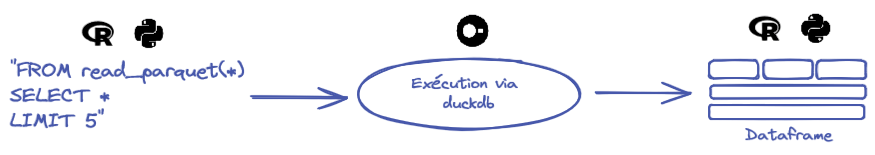

Les calculs ont lieu dans `duckdb` et le résultat est transformé en
*DataFrame* `Pandas` avec la méthode `to_df`.

Le fait de passer par l’intermédiaire de `duckdb` et un fichier
`Parquet` permet d’optimiser les besoins mémoire de `Python`. En effet,
il n’est pas nécessaire d’ouvrir un fichier dans son ensemble, le
transformer en objet `Python` pour n’utiliser qu’une partie des données.
Nous verrons ultérieurement la manière dont les besoins mémoires sont
minimisés grâce au combo `duckdb` & `Parquet`.

Enfin, nous pouvons importer les dictionnaires des variables qui
pourront nous servir ultérieurement:

In [5]:
import pandas as pd

documentation_logement = pd.read_csv("./data/RPlogement_doc.csv", sep = ";")
documentation_individus = pd.read_csv("./data/RPindividus_doc.csv", sep = ";")

# Ouvrir un fichier `Parquet`

## Requêtes sur les colonnes (`SELECT`)

L’une des forces du format `Parquet` est de simplifier l’import de
fichiers volumineux qui ne comportent que quelques colonnes nous
intéressant. Par exemple, la table des individus comporte 88 colonnes,
il est peu probable qu’une seule analyse s’intéresse à toutes celles-ci
(ou elle risque d’être fort indigeste).

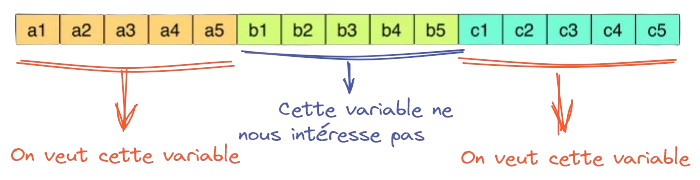

Comme cela est illustré dans **?@tip-optimisation-duckdb**, la
différence de volumétrie entre un fichier non filtré et un fichier
filtré est importante.

In [6]:
query = (
  f"FROM read_parquet(\"{filename_table_individu}\") "
  "SELECT IPONDI AS poids, AGED, VOIT "
  "LIMIT 10"
)
duckdb.sql(query).to_df()

<div class="callout callout-style-default callout-tip callout-titled">
<div class="callout-header d-flex align-content-center">
<div class="callout-icon-container"><i class="callout-icon"></i>
</div>

<div class="callout-title-container flex-fill">
Comprendre l’optimisation permise par Parquet et DuckDB
</div>
</div>

Pour réduire la volumétrie des données importées, il est possible de
mettre en oeuvre deux stratégies:

-   N’importer qu’un nombre limité de colonnes
-   N’importer qu’un nombre limité de lignes

Comme cela a été évoqué dans les *slides*, le format `Parquet` est
particulièrement optimisé pour le premier besoin. C’est donc
généralement la première optimisation mise en oeuvre. Pour s’en
convaincre on peut regarder la taille des données importées dans deux
cas:

-   On utilise beaucoup de lignes mais peu de colonnes
-   On utilise beaucoup de colonnes mais peu de lignes

Pour cela, nous utilisons la fonction SQL `EXPLAIN ANALYZE` disponible
dans `duckdb`. Elle décompose le plan d’exécution de `duckdb`, ce qui
nous permettra de comprendre la stratégie d’optimisation. Elle permet
aussi de connaître le volume de données importées lorsqu’on récupère un
fichier d’internet. En effet, `duckdb` est malin: plutôt que de
télécharger un fichier entier pour n’en lire qu’une partie, la librairie
est capable de n’importer que les blocs du fichier qui l’intéresse.

Ceci nécessite l’utilisation de l’extension `httpfs` (un peu
l’équivalent des `library` de `R` en `duckdb`). Elle s’installe et
s’utilise de la manière suivante

``` python
duckdb.sql("INSTALL httpfs; LOAD httpfs;")
```

Demandons à `DuckDB` d’exécuter la requête *“beaucoup de colonnes, pas
beaucoup de lignes”* et regardons le plan d’exécution et les
informations données par `DuckDB`:

<details>

<summary>

Voir le plan : *“beaucoup de colonnes, pas beaucoup de lignes”*

</summary>

``` python
url_table_logement = files_to_download.get("logements").get("url")
url_table_individu = files_to_download.get("individus").get("url")

plan = duckdb.query(
f"""
EXPLAIN ANALYZE
FROM read_parquet("{url_table_logement}")
SELECT *
LIMIT 5
"""
) 
```

``` python
print(
  plan.to_df()['explain_value'].iloc[0]
)
```

</details>

<details>

<summary>

Voir le plan : *“pas de colonnes, beaucoup de lignes”*

</summary>

``` python
plan = duckdb.sql(
  f"""
  EXPLAIN ANALYZE
  SELECT IPONDI AS poids, AGED, VOIT FROM read_parquet("{url_table_individu}") LIMIT 10000
  """
)
```

``` python
print(
  plan.to_df()['explain_value'].iloc[0]
)
```

</details>

La comparaison de ces plans d’exécution montre l’intérêt de faire un
filtre sur les colonnes : les besoins computationnels sont drastiquement
diminués. Le filtre sur les lignes n’arrive que dans un second temps,
une fois les colonnes sélectionnées.

Pourquoi seulement un rapport de 1 à 4 entre le poids des deux fichiers
? C’est parce que nos requêtes comportent toute deux la variable
`IPONDI` (les poids à utiliser pour extrapoler l’échantillon à la
population) qui est à haute précision là où beaucoup d’autres colonnes
comportent un nombre réduit de modalités et sont donc peu volumineuses.

</div>
</div>

DuckDB propose également des fonctionnalités pour extraire des colonnes
à travers des [expressions
régulières](https://fr.wikipedia.org/wiki/Expression_r%C3%A9guli%C3%A8re).
Cette approche est également possible avec le `tidyverse`

In [12]:
duckdb.sql(
  f"""
    FROM read_parquet(\"{filename_table_individu}\")
    SELECT IPONDI AS poids, COLUMNS('.*AGE.*')
    LIMIT 10
  """
).to_df()

## Requêtes sur les lignes (`WHERE`)

In [13]:
duckdb.sql(
    f"""
    FROM read_parquet("{filename_table_individu}")
    SELECT IPONDI, AGED, DEPT
    WHERE DEPT IN ('11', '31', '34')
    LIMIT 10
    """
).to_df()

Les filtres sur les observations peuvent être faits à partir de critères
sur plusieurs colonnes. Par exemple, pour ne conserver que les
observations de la ville de Nice où la date d’emménagement est
postérieure à 2020, la requête suivante peut être utilisée :

In [14]:
duckdb.sql(
    f"""
    FROM read_parquet("{filename_table_logement}")
    SELECT *
    WHERE COMMUNE = '06088' AND AEMM > 2020
    LIMIT 10
    """
).to_df()

# Statistiques agrégées

## Exemples sans groupes

La fonction `DISTINCT` appliquée à la variable `ARM` permet d’extraire
la liste des codes arrondissements présents dans la base de données.

In [15]:
query = f"""
FROM read_parquet('{filename_table_logement}')
SELECT DISTINCT ARM
WHERE NOT ARM LIKE '%ZZZZZ%'
ORDER BY ARM
"""

result = ", ".join(duckdb.sql(query).to_df()["ARM"])

Il est possible d’extraire des statistiques beaucoup plus raffinées par
le biais d’une requête SQL plus complexe. Par exemple pour calculer le
nombre d’habitants de Toulouse qui ont changé de logement en un an:

In [16]:
query = f"""
FROM read_parquet("{filename_table_logement}")
SELECT CAST(SUM(IPONDL * CAST(INPER AS INT)) AS INT) 
AS habitants_toulouse_demenagement
WHERE COMMUNE = '31555' 
AND IRANM NOT IN ('1', 'Z') 
AND INPER != 'Y'
"""

duckdb.sql(query).to_df()

## Statistiques par groupe

`SQL` et `dplyr` permettent d’aller loin dans la finesse des
statistiques descriptives mises en oeuvre. Cela sera illustré à l’aide
de plusieurs exemples réflétant des statistiques pouvant être
construites grâce à ces données détaillées.

### Exemple 1: pyramide des âges dans l’Aude, l’Hérault et le Gard

Le premier exemple est un comptage sur trois départements. Il illustre
la démarche suivante:

1.  On se restreint aux observations d’intérêt (ici 3 départements)
2.  On applique la fonction `summarise` pour calculer une statistique
    par groupe, en l’occurrence la somme des pondérations
3.  On retravaille les données

Ensuite, une fois que nos données sont récupérées dans `R`, on peut
faire la figure avec `ggplot`

### Exemple 2: répartition des plus de 60 ans par département

L’objectif de ce deuxième exemple est d’illustrer la construction d’une
statistique un peu plus complexe et la manière de projeter celle-ci sur
une carte.

Pour avoir la répartition des plus de 60 ans par département, quelques
lignes de `dplyr` suffisent:

In [18]:
import pandas as pd
import duckdb

# Query to calculate total population and population over 60
part_population_60_plus = duckdb.sql(
    f"""
    FROM read_parquet("{filename_table_individu}")
    SELECT 
        DEPT,
        SUM(IPONDI) AS total_population,
        SUM(CASE WHEN AGED > 60 THEN IPONDI ELSE 0 END) AS population_60_plus
    GROUP BY DEPT
    """
).to_df()

# Calculate percentage of population over 60
part_population_60_plus['pourcentage_60_plus'] = (
    part_population_60_plus['population_60_plus'] / part_population_60_plus['total_population'] * 100
)

# Display the result
part_population_60_plus

Il ne reste plus qu’à projeter ceci sur une carte. Pour cela, un *join*
à notre fond de carte suffit. Comme les données sont agrégées et déjà
dans `R`, il n’y a rien de spécifique à `duckdb` ici.

In [19]:
# Joindre les données au fond de carte des départements

departements_60_plus_gpd = (
  departements
    .merge(
      part_population_60_plus,
      left_on = "INSEE_DEP",
      right_on = "DEPT"
    )
)

Finalement, il ne reste plus qu’à produire la carte:

In [20]:
departements_60_plus_gpd['pourcentage_60_plus_d'] = pd.qcut(
  departements_60_plus_gpd['pourcentage_60_plus'],
  q=4
)

In [21]:
(
  ggplot(departements_60_plus_gpd) +
    geom_map(aes(fill = "pourcentage_60_plus_d")) + 
    scale_fill_brewer(palette = "PuBuGn", direction = 1) + 
    theme_void() + 
    labs(
        title = "Part des personnes de plus de 60 ans par département",
        caption = "Source: Insee, Fichiers détails du recensement de la population",
        fill = "Part (%)"
    )
)

Si on préfère représenter ceci sous forme de tableau, on peut utiliser
le *package*
[`great tables`](https://posit-dev.github.io/great-tables/articles/intro.html).
Cela nécessite quelques manipulations de données en amont.

In [22]:
part_population_60_plus_dep = part_population_60_plus.merge(
  departements.loc[:, ["INSEE_DEP", "LIBELLE_DEPARTEMENT"]],
  left_on = "DEPT",
  right_on = "INSEE_DEP"
)
part_population_60_plus_dep["departement"] = part_population_60_plus_dep["LIBELLE_DEPARTEMENT"] + " (" + part_population_60_plus_dep["DEPT"]  + ")"

part_population_60_plus_dep = part_population_60_plus_dep.sort_values("pourcentage_60_plus", ascending=False).head(10)

In [23]:
from great_tables import *
(
  GT(
    part_population_60_plus_dep.loc[
      :, ['departement', 'total_population', 'population_60_plus', 'pourcentage_60_plus']
    ]
  )
  .fmt_number(columns=[
    "total_population", "population_60_plus"
  ], compact=True)
  .fmt_percent("pourcentage_60_plus", scale_values = False)
  .fmt_nanoplot(columns="pourcentage_60_plus", plot_type="bar")
)

### Exemple 3: part des résidences secondaires et des logements vacants

Il est tout à fait possible de faire des étapes antérieures de
préparation de données, notamment de création de variables avec
`mutate`.

L’exemple suivant illustre la préparation de données avant la
construction de statistiques descriptives de la manière suivante:

1.  Création d’une variable de département à partir du code commune
2.  Décompte des logements par département

**Suite du tutoriel à venir**

In [24]:
import shutil
shutil.rmtree("data")